In [1]:
import numpy as np
import pandas as pd 
import obspy
import creep_event_picker as cep
import datetime as dt
import matplotlib.pyplot as plt
import inflect
stringify = inflect.engine()
import math
import os
import raw_to_obspy as rto
from os import listdir
from os.path import isfile, join

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [10]:
network = 'East_Anatolian_Fault'
#station = ['crr','cwc3','cwn','tabc','wkr','x46','xgh','xhr','xhr1','xhr2','xhsw','xmbc','xmd','xmm','xmr','xpk','xpk1','xrsw','xsc','xsj','xsj2','xta','xva']
station = ['sri']
path = "../../../Data/{p}/SAC".format(p=network)
rto.check_dir(path)
#Creepmeter_dataframe = pd.DataFrame(columns = ['Network','Creepmeter','Start Time','End Time','Sampling rate, Hz','Sampling rate, mins','Latitude','Longitude'])
#Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
Creepmeter_dataframe = pd.read_csv('../../../Data/creepmeter_lookup.csv',index_col=0)

Import data and create .SAC files for USGS creepmeters

c46


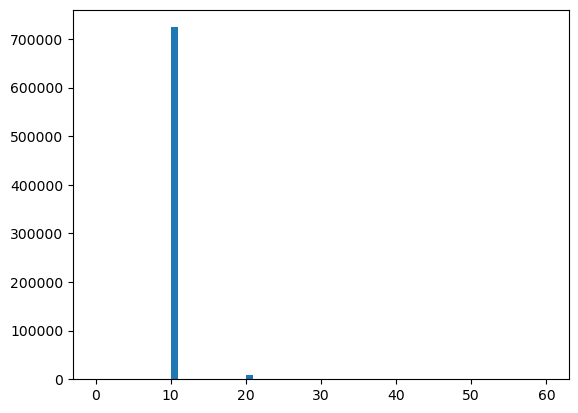

[10]
[10] ['C']
interpolating creeping_C


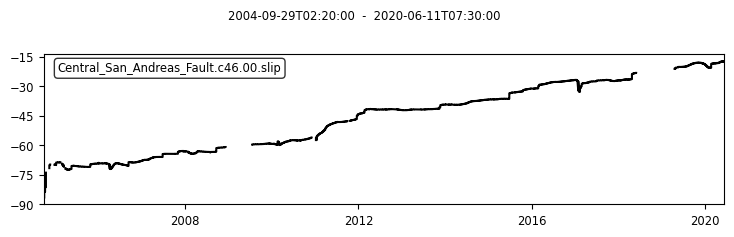

No A
No B
                       Network                 Creepmeter_full_name  \
0              Calaveras_Fault                          Shore Rd #1   
1                Hayward_Fault                       Fremont Winery   
2                Hayward_Fault                       Fremont Winery   
3                Hayward_Fault                       Fremont Winery   
4                Hayward_Fault              Hayward Palisades St #2   
5                Hayward_Fault              Hayward Palisades St #3   
6                Hayward_Fault                          Oakland Zoo   
7                Hayward_Fault                          Oakland Zoo   
8                Hayward_Fault                          Oakland Zoo   
9                Hayward_Fault                            Pt Pinole   
10               Hayward_Fault                            Pt Pinole   
11               Hayward_Fault                             Temescal   
12               Hayward_Fault                             Temescal

In [5]:
for j in range(len(station)):
    #creeping, tm_diff = rto.import_USGS(station[j],network)
    creeping, tm_diff = rto.import_USGS_C46(station[j],network)

    plt.figure()
    bins = np.arange(0,61,1)
    plt.hist(tm_diff,bins=bins)
    plt.show()


    bins_hist, hist_val = np.histogram(tm_diff,bins)
    boolarr = bins_hist > 150000
    periods = hist_val[1:][boolarr] -1
    print(periods)

    if len(periods) >= 2:
        print('warning, this needs thinking about majorly!')

        a = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[0]), g = stringify.number_to_words(periods[1])))
        b = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[1]), g = stringify.number_to_words(periods[0])))

        creeping_A = creeping.iloc[:a]
        creeping_B = creeping.iloc[a:b]
        creeping_C = creeping.iloc[b:]
    elif len(periods) == 1: 
        creeping_C = creeping.iloc[0:]
    

    Number_of_splits = []
    Sampling_rates_variable = []
    try:
        sampling_A = round((creeping_A.Tm.iloc[2] - creeping_A.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_A)
        Number_of_splits.append('A')
    except (IndexError, NameError):
        sampling_A = 0

    try:
        sampling_B = round((creeping_B.Tm.iloc[2] - creeping_B.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_B)
        Number_of_splits.append('B')
    except (IndexError, NameError):
        sampling_B = 0

    try:
        sampling_C = round((creeping_C.Tm.iloc[2] - creeping_C.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_C)
        Number_of_splits.append('C')
    except (IndexError, NameError):
        sampling_C = 0

    print(Sampling_rates_variable,Number_of_splits)
    #print(creeping_A,creeping_B,creeping_C)


    for i in range(len(Number_of_splits)):
        print('interpolating creeping_{k}'.format(k=Number_of_splits[i]))
        upsampled = rto.interpolate(eval('creeping_{k}'.format(k=Number_of_splits[i])),Sampling_rates_variable[i])
        val1_okay = math.isnan(upsampled.Creep.iloc[0])
        if val1_okay == True:
            upsampled.reset_index(inplace=True)
            upsampled.drop([0],axis=0,inplace=True)
        tr = obspy.Trace(np.array(upsampled.Creep))
        st = obspy.Stream(tr)
        st[0].stats.network = network
        st[0].stats.station = station[j]
        st[0].stats.location = '00'
        st[0].stats.channel = 'slip'
        st[0].stats.starttime = upsampled.Tm.iloc[0]
        st[0].stats.delta = 60*Sampling_rates_variable[i]
        st[0].plot()
        instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_full_name':'please fill','Creepmeter_abbrv':'please fill','File_code':['{p}_{q}'.format(p=station[j],q=i)],'Start Time':[st[0].stats.starttime],\
                                   'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],\
                                    'Sampling rate, mins':(1/st[0].stats.sampling_rate)/60,'Latitude':['please fill'],'Longitude':['please fill']})
        
        Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument])
        st.write(path +'/{p}_{q}.SAC'.format(p=station[j],q=i),format='SAC')
    try:
        del(creeping_A)
    except NameError:
        print('No A')
    try:
        del(creeping_B)
    except NameError:
        print('No B')
    try: 
        del(creeping_C)
    except NameError:
        print('No C')
Creepmeter_dataframe.drop_duplicates('File_code',inplace=True)
Creepmeter_dataframe.reset_index(inplace=True)
Creepmeter_dataframe.drop(['index'], axis=1,inplace=True)
Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
print(Creepmeter_dataframe)

In [4]:
creeping

,Time,Tm,Creep
0,2004-09-29 02:19:59.999981,2004-09-29 02:19:59.999981,-86.572
1,2004-09-29 02:30:00.000029,2004-09-29 02:30:00.000029,-86.625
2,2004-09-29 02:39:59.999990,2004-09-29 02:39:59.999990,-86.617
3,2004-09-29 02:50:00.000038,2004-09-29 02:50:00.000038,-86.612
4,2004-09-29 03:00:00.000000,2004-09-29 03:00:00.000000,-86.607
...,...,...,...
732264,2020-06-11 06:49:59.999981,2020-06-11 06:49:59.999981,-17.328
732265,2020-06-11 07:00:00.000029,2020-06-11 07:00:00.000029,-17.328
732266,2020-06-11 07:09:59.999990,2020-06-11 07:09:59.999990,-17.328
732267,2020-06-11 07:20:00.000038,2020-06-11 07:20:00.000038,-17.328


Import data and create .SAC files for Roger's creepmeters

warning, sample rate may have changed, consider splitting
oh no
0
                       Time                  Tm    Creep
1916590 2020-09-14 08:56:30 2020-09-14 08:56:30 -26.5950
1916591 2020-09-14 08:56:40 2020-09-14 08:56:40 -26.5948
1916592 2020-09-14 08:56:50 2020-09-14 08:56:50 -26.5950
1916593 2020-09-14 08:57:00 2020-09-14 08:57:00 -26.5950
1916594 2020-09-14 08:57:10 2020-09-14 08:57:10 -26.5948
1916595 2020-09-14 08:57:20 2020-09-14 08:57:20 -26.5950
1916596 2020-09-14 08:57:30 2020-09-14 08:57:30 -26.5952
1916597 2020-09-14 08:57:40 2020-09-14 08:57:40 -26.5948
1916598 2020-09-14 08:57:50 2020-09-14 08:57:50 -26.5952
1916599 2020-09-14 08:58:00 2020-09-14 08:58:00 -26.5950


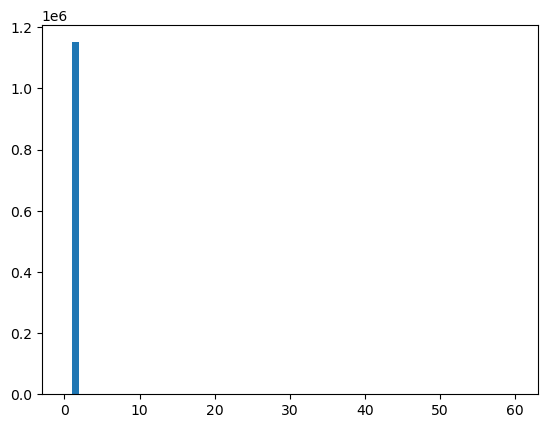

[1]
[1] ['C']
                       Time                  Tm     Creep
0       2020-02-05 11:48:01 2020-02-05 11:48:01 -120.5900
1       2020-02-05 11:48:11 2020-02-05 11:48:11 -120.4170
2       2020-02-05 11:48:21 2020-02-05 11:48:21 -120.4110
3       2020-02-05 11:48:31 2020-02-05 11:48:31 -120.4110
4       2020-02-05 11:48:41 2020-02-05 11:48:41 -120.4070
...                     ...                 ...       ...
5104859 2023-12-02 11:15:00 2023-12-02 11:15:00    5.0262
5104860 2023-12-02 11:16:00 2023-12-02 11:16:00    5.0262
5104861 2023-12-02 11:17:00 2023-12-02 11:17:00    5.0258
5104862 2023-12-02 11:18:00 2023-12-02 11:18:00    5.0258
5104863 2023-12-02 11:19:00 2023-12-02 11:19:00    5.0262

[5104864 rows x 3 columns]
interpolating creeping_C
1
No A
No B
                       Network                 Creepmeter_full_name  \
0              Calaveras_Fault                          Shore Rd #1   
1                Hayward_Fault                       Fremont Winery   
2           

In [11]:
for j in range(len(station)):
    creeping, tm_diff = rto.import_csv_roger(station[j],network)

    plt.figure()
    bins = np.arange(0,61,1)
    plt.hist(tm_diff,bins=bins)
    plt.show()


    bins_hist, hist_val = np.histogram(tm_diff,bins)
    boolarr = bins_hist > 50000
    periods = hist_val[1:][boolarr] -1
    print(periods)

    if len(periods) >= 2:
        print('warning, this needs thinking about majorly!')

        a = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[0]), g = stringify.number_to_words(periods[1])))
        b = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[1]), g = stringify.number_to_words(periods[0])))

        creeping_A = creeping.iloc[:a]
        creeping_B = creeping.iloc[a:b]
        creeping_C = creeping.iloc[b:]
    elif len(periods) == 1: 
        creeping_C = creeping.iloc[0:]
    

    Number_of_splits = []
    Sampling_rates_variable = []
    try:
        sampling_A = round((creeping_A.Tm.iloc[2] - creeping_A.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_A)
        Number_of_splits.append('A')
    except (IndexError, NameError):
        sampling_A = 0

    try:
        sampling_B = round((creeping_B.Tm.iloc[2] - creeping_B.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_B)
        Number_of_splits.append('B')
    except (IndexError, NameError):
        sampling_B = 0

    try:
        sampling_C = round((creeping_C.Tm.iloc[-1] - creeping_C.Tm.iloc[-2])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_C)
        Number_of_splits.append('C')
    except (IndexError, NameError):
        sampling_C = 0

    print(Sampling_rates_variable,Number_of_splits)
    print(creeping_C)
#

    for i in range(len(Number_of_splits)):
        print('interpolating creeping_{k}'.format(k=Number_of_splits[i]))
        upsampled = rto.interpolate(eval('creeping_{k}'.format(k=Number_of_splits[i])),Sampling_rates_variable[i])
        val1_okay = math.isnan(upsampled.Creep.iloc[0])
        if val1_okay == True:
            upsampled.reset_index(inplace=True)
            upsampled.drop([0],axis=0,inplace=True)
        tr = obspy.Trace(np.array(upsampled.Creep))
        st = obspy.Stream(tr)
        st[0].stats.network = network
        st[0].stats.station = station[j]
        st[0].stats.location = '00'
        st[0].stats.channel = 'slip'
        st[0].stats.starttime = pd.to_datetime(upsampled.Tm.iloc[0])
        st[0].stats.delta = 60*Sampling_rates_variable[i]
        #st[0].plot()
        instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_full_name':'please fill','Creepmeter_abbrv':'please fill','File_code':['{p}_{q}'.format(p=station[j],q=i)],'Start Time':[st[0].stats.starttime],\
                                   'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],\
                                    'Sampling rate, mins':(1/st[0].stats.sampling_rate)/60,'Latitude':['please fill'],'Longitude':['please fill']})
        
        Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument])
        st.write(path +'/{p}_{q}.SAC'.format(p=station[j],q=i),format='SAC')
    try:
        del(creeping_A)
    except NameError:
        print('No A')
    try:
        del(creeping_B)
    except NameError:
        print('No B')
    try: 
        del(creeping_C)
    except NameError:
        print('No C')

#Creepmeter_dataframe.drop_duplicates('File_code',inplace=True)
Creepmeter_dataframe.reset_index(inplace=True)
Creepmeter_dataframe.drop(['index'], axis=1,inplace=True)
Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
print(Creepmeter_dataframe)

1

In [8]:
creeping_C

,Time,Tm,Creep
391188,2019-03-29 22:46:43,2019-03-29 22:46:43,-17.5654
391189,2019-03-29 23:00:18,2019-03-29 23:00:18,-17.5654
391190,2019-03-29 23:00:20,2019-03-29 23:00:20,-17.5654
391191,2019-03-29 23:00:22,2019-03-29 23:00:22,-17.5654
391192,2019-03-29 23:00:24,2019-03-29 23:00:24,-17.5654
...,...,...,...
2767610,2023-10-07 11:05:00,2023-10-07 11:05:00,3.3320
2767611,2023-10-07 11:06:00,2023-10-07 11:06:00,3.3320
2767612,2023-10-07 11:07:00,2023-10-07 11:07:00,3.3320
2767613,2023-10-07 11:08:00,2023-10-07 11:08:00,3.3300


Adding info to creepmeters database

In [18]:
Creepmeter_dataframe = pd.read_csv('../../../Data/creepmeter_lookup.csv',index_col=0)
Creepmeter_dataframe

,Network,Creepmeter_full_name,Creepmeter_abbrv,File_code,Start Time,End Time,"Sampling rate, Hz","Sampling rate, mins",Latitude,Longitude
0,Calaveras_Fault,Shore Rd #1,XSH1,xsh_0,2020-10-15T17:02:00.000000Z,2023-03-30T05:01:00.000000Z,0.016667,1,36.9430,-121.4450
1,Hayward_Fault,Fremont Winery,CFW1,cfw_0,1993-12-15T01:00:00.000000Z,1999-07-02T00:00:00.000000Z,0.000278,60,37.5320,-121.9520
2,Hayward_Fault,Fremont Winery,CFW1,cfw_1,1999-07-03T20:00:00.000000Z,2020-01-07T19:10:00.000000Z,0.001667,10,37.5320,-121.9520
3,Hayward_Fault,Fremont Winery,CFW1,cfw_2,2020-01-07T19:25:00.000000Z,2024-02-05T14:17:00.000000Z,0.016667,1,37.5320,-121.9520
4,Hayward_Fault,Hayward Palisades St #2,CHP1,chp_0,1994-04-02T01:20:00.000000Z,2020-01-07T22:10:00.000000Z,0.001667,10,37.6630,-122.0740
5,Hayward_Fault,Hayward Palisades St #3,CHP1,chp_1,2020-01-08T01:01:00.000000Z,2024-02-05T14:09:00.000000Z,0.016667,1,37.6630,-122.0740
6,Hayward_Fault,Oakland Zoo,COZ1,coz_0,1996-11-06T09:00:00.000000Z,2006-08-30T20:00:00.000000Z,0.000278,60,37.7530,-122.1500
7,Hayward_Fault,Oakland Zoo,COZ1,coz_1,2006-08-30T21:00:00.000000Z,2020-01-07T17:10:00.000000Z,0.001667,10,37.7530,-122.1500
8,Hayward_Fault,Oakland Zoo,COZ1,coz_2,2020-01-07T17:24:00.000000Z,2024-02-05T14:07:00.000000Z,0.016667,1,37.7530,-122.1500
9,Hayward_Fault,Pt Pinole,CPP1,cpp_0,1995-08-25T20:00:00.000000Z,2020-01-20T23:40:00.000000Z,0.001667,10,37.9900,-122.3560


Creating CSV areas

In [8]:
test_2 = pd.read_csv("../../../Data/East_Anatolian_Fault/Raw/Sivrice2020_3.txt")

In [9]:
test_2.rename(columns={'SivriceDay':'Date','Sivricemm':'Slip'},inplace=True)
test_2.drop(['SivricdegC'], axis=1,inplace=True)
test_2.to_csv('../../../Data/East_Anatolian_Fault/CSV/sri.csv')

In [ ]:
test_2 = pd.read_csv("../../../Data/Southern_San_Andreas_Fault/Ross_Road_Imperial_to_2022.txt")

In [ ]:
test_2

In [ ]:
test_2.drop(['coRRC'],axis=1)

In [3]:
rr_23 = pd.read_csv('../../../Southern_CA_creepmeter_data/Ross_road_2022_2023.txt')
rr_23.rename(columns = {'SoCalDate':'Date','RR':'Slip'},inplace=True)
rr_to_22 = pd.read_csv('../../../Southern_CA_creepmeter_data/Ross_Road_Imperial_to_2022.txt')
rr_to_22.rename(columns={'coRRDAY':'Date','coRR':'Slip'},inplace=True)
rr_to_22.drop(['coRRC'], axis=1,inplace=True)

Ross_road=pd.concat([rr_to_22,rr_23],ignore_index=True)

In [5]:
Ross_road

,Date,Slip
0,08/08/2010 20:25:22,-37.7481
1,08/08/2010 20:55:22,-37.7481
2,08/08/2010 21:25:22,-37.7481
3,08/08/2010 21:55:22,-37.7481
4,08/08/2010 22:25:22,-37.7841
...,...,...
2767611,10/07/2023 11:05:00,3.3320
2767612,10/07/2023 11:06:00,3.3320
2767613,10/07/2023 11:07:00,3.3320
2767614,10/07/2023 11:08:00,3.3300


In [6]:
Ross_road.to_csv('../../../Data/Southern_San_Andreas_Fault/CSV/rr.csv')

In [ ]:
Ross_road

In [ ]:
sh_23 = pd.read_csv('../../../Southern_CA_creepmeter_data/Superstition_to_Oct_2023.txt')
sh_23.rename(columns={'newSUtime':'Date','newSUmm1':'Slip','newSUC':'TempC'},inplace=True)
sh_23.Date = pd.to_datetime(sh_23.Date)
sh_23.to_csv('../../../Data/Southern_San_Andreas_Fault/CSV/sup2.csv')

In [ ]:
sh_04_19 = pd.read_csv('../../../Southern_CA_creepmeter_data/Superstition-2004_2019.txt')
sh_04_19.rename(columns={'SHday':'Date','SHmm':'Slip','SHT':'TempC'},inplace=True)
sh_04_19.Date = pd.to_datetime(sh_04_19.Date)
plt.figure()
plt.plot(sh_04_19.Date,sh_04_19.Slip)
plt.show()
sh_04_19.to_csv('../../../Data/Southern_San_Andreas_Fault/CSV/sup1.csv')

In [ ]:
sh_combo  = pd.concat([sh_04_19,sh_23])

In [ ]:
sh_combo.drop_duplicates(subset='Date',inplace=True)
sh_combo.to_csv('../../../Data/Southern_San_Andreas_Fault/CSV/sup.csv')

In [ ]:
plt.figure()
plt.plot(sh_combo.Date,sh_combo.Slip)
plt.show()

In [ ]:
durmid = pd.read_csv('../../../Data/Southern_San_Andreas_Fault/Raw/Durmid Hill Creep 2004-2024.txt')

In [ ]:
durmid.rename(columns={'SoCalDate':'Date','Durmid':'Slip'},inplace=True)
durmid.Date = pd.to_datetime(durmid.Date)
durmid.to_csv('../../../Data/Southern_San_Andreas_Fault/CSV/dmh.csv')

In [15]:
#wsz = pd.read_csv("../../../Data/North_Anatolian_Fault/CSV/wsz.csv",names=['Date','Slip'])
wsz.to_csv("../../../Data/North_Anatolian_Fault/CSV/wsz.csv")

In [14]:
#wsz.reset_index(inplace=True)
#wsz.drop([0,1],inplace=True)
#wsz.drop(['level_0','index'],axis=1,inplace=True)
#wsz.reset_index(inplace=True)
wsz.drop(['index'],axis=1,inplace=True)
wsz

,Date,Slip
0,2017-12-04 09:08:27,3.69
1,2017-12-04 09:13:27,3.69
2,2017-12-04 09:18:27,3.69
3,2017-12-04 09:23:27,3.69
4,2017-12-04 09:28:27,3.69
...,...,...
2312042,2023-06-07 12:16:17,8.2322
2312043,2023-06-07 12:17:17,8.2322
2312044,2023-06-07 12:18:17,8.2322
2312045,2023-06-07 12:19:17,8.2537


In [ ]:
inw = pd.read_csv("../../../Data/North_Anatolian_Fault/RAW/Ismetpasa North Wall 2004-2023.txt")

In [ ]:
inw.rename(columns={'northday':'Date','northamm':'Slip'},inplace=True)

In [ ]:
inw.to_csv("../../../Data/North_Anatolian_Fault/CSV/inw.csv")

In [4]:
isw = pd.read_csv("../../../Data/North_Anatolian_Fault/RAW/southwall ismetpasa.txt")

In [6]:
isw.rename(columns={'transmittedDAY1':'Date','TransSmm1':'Slip','transDegC1':'TempC'},inplace=True)

In [8]:
isw.drop(['TempC'],axis=1,inplace=True)

In [9]:
isw.to_csv("../../../Data/North_Anatolian_Fault/CSV/isw.csv")

In [14]:
cha = pd.read_csv("../../../Data/Chaman_Fault/RAW/Chaman creep event 2019 _ hourly data.txt")

In [17]:
cha.rename(columns={'chamanDay':'Date','mm':'Slip'},inplace=True)
cha.to_csv("../../../Data/Chaman_Fault/CSV/cha.csv")

In [11]:
fc = pd.read_csv("../../../Data/Central_San_Andreas_Fault/Raw/FoxCreekSouth to March 2024.txt")
fc.drop(['FoxSouthNormal','FoxSouthdegC'],inplace=True,axis=1)
fc.rename(columns = {'FoxSouthOblique':'Slip','FoxSouthDAY':'Date'},inplace=True)
fc.to_csv("../../../Data/Central_San_Andreas_Fault/CSV/fxc.csv")